In [1]:
import os
import numpy

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as tck

In [3]:
npy_folder = r'D:\PhD_Workspace\MISR_AHI_WS\240113\original'
npy_file = 'MISR_RAA-matched_infos_10km.npy'
npy_filename = os.path.join(npy_folder, npy_file)

In [4]:
save_folder = r'D:\PhD_Workspace\MISR_AHI_WS\240113\display'

In [5]:
matched_record = numpy.load(npy_filename)

In [6]:
# get side of VAA-to-SAA (SAA as refer)
def get_side_RAA(vaa, saa):
    if saa < 180:
        if vaa > saa and vaa < saa + 180:
            return 1
        else:
            return -1
    if saa > 180:
        if vaa > saa - 180 and vaa < saa:
            return -1
        else:
            return 1

        
def is_only_raa(geo_vaa, geo_saa, leo_vaa, leo_saa):
    geo_dif = get_side_RAA(float(geo_vaa), float(geo_saa))
    leo_dif = get_side_RAA(float(leo_vaa), float(leo_saa))
    if geo_dif*leo_dif > 0:
        return 0
    else:
        return 1

In [7]:
season_loc_record = []
season_monidx = [[0,1,2], [3,4,5], [6,7,8], [9,10,11]]
for season_idx in range(len(season_monidx)):
    season_mon_idx_list = season_monidx[season_idx]
    count_dict = {}
    month_str_list = []
    for season_moidx in season_mon_idx_list:
        season_month = season_moidx+1
        month_str = (2-len(str(season_month)))*'0'+str(season_month)
        month_str_list.append(month_str)
    for record_item in matched_record:
        time_str = record_item[5]
        record_month = time_str[4:6]
        if record_month in month_str_list:
            leo_vaa = record_item[9]
            leo_saa = record_item[13]
            geo_vaa = record_item[10]
            geo_saa = record_item[14]
            if is_only_raa(geo_vaa, geo_saa, leo_vaa, leo_saa):
                loc_lon = record_item[0]
                loc_lat = record_item[1]
                loc_lon_lat = loc_lon+ ',' + loc_lat
                if loc_lon_lat in count_dict:
                    count_dict[loc_lon_lat] = count_dict[loc_lon_lat] + 1
                else:
                    count_dict[loc_lon_lat] = 1
    season_loc_record.append(count_dict)

34.0
24.0


C:\Users\Beichen\AppData\Roaming\Python\Python310\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\Beichen\AppData\Roaming\Python\Python310\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\Beichen\AppData\Roaming\Python\Python310\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
C:\Users\Beichen\AppData\Roaming\Python\Python310\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels t

18.0
26.0


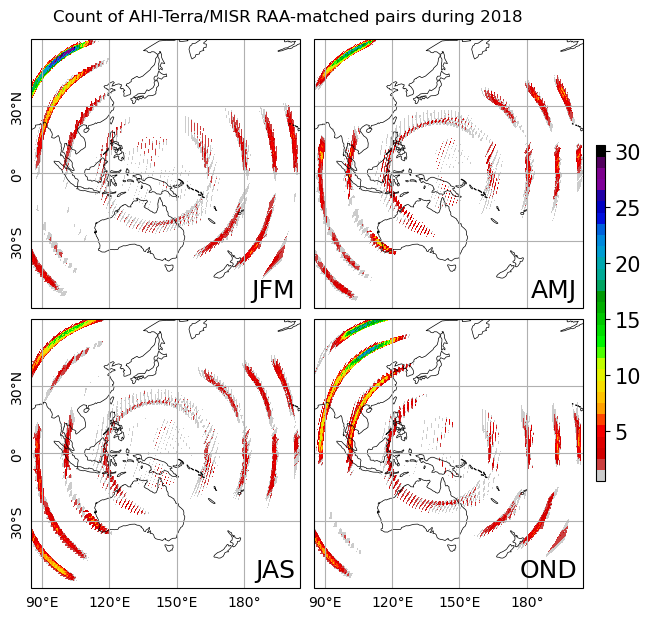

In [9]:
season_labels = ['JFM', 'AMJ', 'JAS', 'OND']

ahi_extent = (85.0-180, 205-180, -60.0, 60.0)
proj=ccrs.PlateCarree()

norm = matplotlib.colors.Normalize(vmin=0.5, vmax=30.5)
cmap = plt.get_cmap('nipy_spectral_r',lut = 30)

# mapping
row_count = 2
col_count = 2
fig, axes = plt.subplots(row_count, col_count, figsize=(9.5, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
season_idx = 0
for row in range(row_count):
    for col in range(col_count):
        count_dict = season_loc_record[season_idx]
        ahi_array_2d = numpy.zeros((1200,1200))
        resolutoin_pixel = 0.1
        ahi_llon = 85.0
        ahi_llat = 60.0
        for lon_lat, loc_count in count_dict.items():
            lon_str, lat_str = lon_lat.split(',')
            lon_idx = int((float(lon_str) - ahi_llon)/resolutoin_pixel)
            lat_idx = int((ahi_llat - float(lat_str))/resolutoin_pixel)
            ahi_array_2d[lat_idx][lon_idx] = loc_count
        fig_show = numpy.copy(ahi_array_2d)
        fig_show[fig_show==0]=numpy.NaN
        print(ahi_array_2d.max())
        axes[row, col].add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
        
        im = axes[row, col].imshow(fig_show, extent=ahi_extent, cmap=cmap, norm=norm, interpolation='None')
        
        gl=axes[row, col].gridlines(crs=proj,draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_right = False
        if col > 0:
            gl.ylabels_left = False
        if row < row_count-1:
            gl.xlabels_bottom = False
        gl.xlocator = tck.FixedLocator(numpy.arange(-180,180,30))
        gl.ylocator = tck.FixedLocator(numpy.arange(-90,90,30))
        gl.ylabel_style = {'rotation': 90}
        
        axes[row, col].text(0.98, 0.02, season_labels[season_idx], transform=axes[row, col].transAxes, ha='right', va='bottom', fontsize=18, color='black')

        season_idx+=1

plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15, wspace=0.05, hspace=0)

cbar = fig.colorbar(im, ax=axes, location='right', orientation='vertical', aspect=40, fraction=0.15, pad=0.02, shrink=0.6)
plt.suptitle('Count of AHI-Terra/MISR RAA-matched pairs during 2018', x=0.42, y=0.88, fontsize=12)
    
# cbar.set_ticks(numpy.arange(1,13))
cbar.ax.tick_params(labelsize=15)

plt.savefig(os.path.join(save_folder, npy_file[:-14]+'season_count.png'), bbox_inches='tight', dpi=500)
plt.show()